In [12]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_neuro_perf
from qt_wrapper import gui_fpath

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/TNU2019-Project/src/lib


## 0. Loading data

In [5]:
# Read neuronal and behavioural data from containing folder
#  NOTE: USE GUI TO SELECT ANOTHER DATA PATH IF NECESSARY
# data_path = gui_fpath("Select data directory", "./")
data_path = "../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour"
data, behaviour = read_neuro_perf(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

Reading Yaro data from ../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour
Loaded neuronal data with (nTrials, nTimes, nChannels)= (590, 201, 12)


# Cross-Correlation

First attempt at studying the data - autocorrelation. Should give indication at how well the data predicts itself

**Conclusions**:
* Why are there oscillations in the autocorrelation - ah, of course, it is typical for data convolved with a decaying exponential :)
* Data significantly autocorrelated - for most channel pairs it is best explained by 0-time-shift. Hence, using autoregression to predict data may have potential
* Channels appear to cluster by correlation coefficient - indicative of underlying whole-brain dynamics

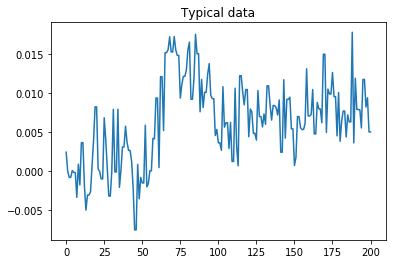

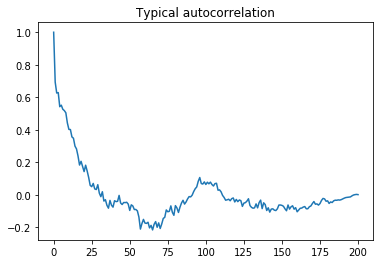

In [8]:
# Compute correlation coefficient
def crosscorr(x, y, withNorm = True):
    xdev = x - np.mean(x)
    ydev = y - np.mean(y)
    rez = np.correlate(xdev, ydev, mode='full')[x.size-1:]
    if withNorm:
        s2_x = np.correlate(xdev, xdev)
        s2_y = np.correlate(ydev, ydev)
        return rez / np.sqrt(s2_x * s2_y)
    else:
        return rez


EXAMPLE_TRIAL = 0
EXAMPLE_CHANNEL = 2
EXAMPLE_DATA = data[EXAMPLE_TRIAL, :, EXAMPLE_CHANNEL]

    
plt.figure()
plt.title("Typical data")
plt.plot(EXAMPLE_DATA)
plt.show()
    
plt.figure()
plt.title("Typical autocorrelation")
plt.plot(crosscorr(EXAMPLE_DATA, EXAMPLE_DATA))
plt.show()

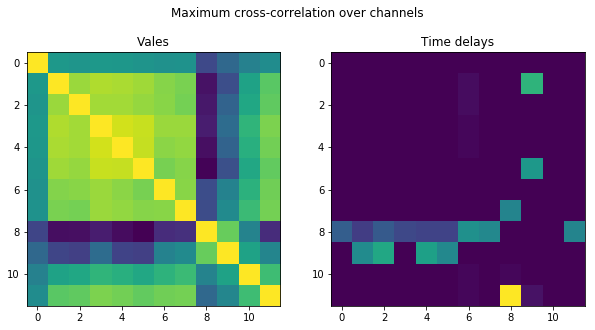

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.347753,0.331961,0.350462,0.342486,0.327077,0.310356,0.318605,-0.088006,0.077940,0.215972,0.281138
1,0.347753,1.000000,0.790161,0.831235,0.820378,0.798875,0.744959,0.721339,-0.327868,-0.062358,0.409460,0.642097
2,0.331961,0.790161,1.000000,0.804941,0.806574,0.780060,0.753975,0.706919,-0.303068,0.050583,0.434278,0.657392
3,0.350462,0.831235,0.804941,1.000000,0.902241,0.885215,0.791581,0.789426,-0.281224,0.095510,0.516975,0.722752
4,0.342486,0.820378,0.806574,0.902241,1.000000,0.877291,0.758421,0.774756,-0.336230,0.049710,0.482850,0.702477
5,0.327077,0.798875,0.780060,0.885215,0.877291,1.000000,0.715223,0.744695,-0.380258,-0.056951,0.442664,0.663777
6,0.310356,0.742616,0.750778,0.791286,0.756975,0.715223,1.000000,0.752551,-0.064323,0.225858,0.502569,0.698640
7,0.318605,0.721339,0.706919,0.789426,0.774756,0.744695,0.752551,1.000000,-0.069526,0.272639,0.554767,0.708434
8,-0.104751,-0.343135,-0.338799,-0.284439,-0.347692,-0.394909,-0.216435,-0.200794,1.000000,0.674614,0.227612,-0.217640
9,0.077940,-0.105811,-0.132412,0.095510,-0.115765,-0.128783,0.225858,0.272639,0.674614,1.000000,0.409518,0.242468


,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,2,0,0,39,0,0
2,0,0,0,0,0,0,2,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,32,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,27,0,0,0
8,18,11,17,13,12,12,30,28,0,0,0,27
9,0,29,36,0,34,28,0,0,0,0,0,0


In [16]:
# Compute cross-correlation coefficient all trials
def crosscorr_multitrial(xx, yy):
    sumautox = np.sum([np.correlate(x - np.mean(x), x - np.mean(x)) for x in xx])
    sumautoy = np.sum([np.correlate(y - np.mean(y), y - np.mean(y)) for y in yy])
    sumcorr = np.sum([crosscorr(x, y, False) for x,y in zip(xx, yy)], axis=0)
    return sumcorr / np.sqrt(sumautox * sumautoy)
    

corr_max  = np.zeros((nChannels, nChannels))
corr_maxt = np.zeros((nChannels, nChannels), dtype=int)

for iCh in range(nChannels):
    for jCh in range(nChannels):
        corr = crosscorr_multitrial(data[:, :, iCh], data[:, :, jCh])#[:25]
        corr_maxt[iCh][jCh] = np.argmax(np.abs(corr))
        corr_max[iCh][jCh]  = corr[corr_maxt[iCh][jCh]]
        

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Maximum cross-correlation over channels")
ax[0].imshow(corr_max)
ax[0].set_title("Vales")
ax[1].imshow(corr_maxt)
ax[1].set_title("Time delays")
plt.show()

display(HTML('<strong>Maximum cross-correlation matrix</strong><br/>'))
display(pd.DataFrame(corr_max))
display(HTML('<strong>Maximum cross-correlation time-delays</strong><br/>'))
display(pd.DataFrame(corr_maxt))

# Synchronization Coefficient

### **NOTE:** This part requires neuronal data from a single mouse over several days. It is not possible to run this part outside of our lab at the moment. Thank you for your understanding.

Let data be given by $Data_{ijk}$, where the coefficients stand for number of trials, time steps and channels respectively. Define the flattened version $Data_{ij}$, where time steps and trials have been flattened into a single index $i$. Then, define the correlation matrix as

$$C_{ij} = CORR(Data_{:, i}, Data_{:, j})$$

Define synchronization coefficient as

$$S = \frac{1}{N^2 - N}\sum_{ij} |C_{ij}| - \delta_{ij}$$

Plot Synchronization coefficient over days

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_10_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_13_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_14_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_15_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_16_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_17_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_20_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_21_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_22_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_23_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_24_a

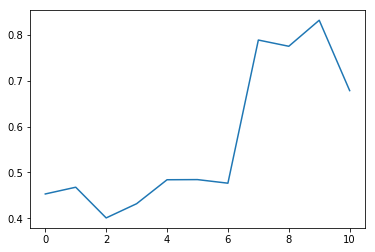

In [134]:
# Read LVM file from command line

synchrony_by_day = []

data_path_parent = gui_fpath("Select data parent directory", data_path)
subdirs = next(os.walk(data_path_parent))[1]
for subdir in subdirs:
    dirpath = os.path.join(data_path_parent, subdir)
#     print("Processing", dirpath)

    # Get data
    data, behaviour = read_neuro_perf(dirpath)
    
    # Get parameters
    nTrials, nTimes, nChannels = data.shape
    
    data2D = []
    
    for iCh in range(nChannels):
        dataChannel = []
        for iTr in range(nTrials):
            dataChannel += [data[iTr, :, iCh] - np.mean(data[iTr, :, iCh])]
        data2D += [np.array(dataChannel).flatten()]
            
    # Compute normalization variances
    s_data = [np.sqrt(np.correlate(d, d)) for d in data2D]
    
    # Compute correlation
    cr = np.zeros((nChannels, nChannels))
    for iCh in range(nChannels):
        for jCh in range(iCh+1, nChannels):
            cr[iCh][jCh] = np.correlate(data2D[iCh], data2D[jCh]) / (s_data[iCh] * s_data[jCh])
            
    synchrony_by_day += [np.sum(np.abs(cr)) * 2 / nChannels / (nChannels - 1)]
    
plt.figure()
plt.plot(synchrony_by_day)
plt.show()